# Determining the cost of vehicles

A used car dealership is developing an app to attract new customers. In it, you can quickly find out the market value of your car. Historical data is available: technical characteristics, configurations and prices of vehicles. We need to build a model to determine the cost.

#### Consumer value :
- quality of prediction;
- prediction speed;
- training time.

### Data preparation :


In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import time
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('autos.csv')

#### Signs:
- DateCrawled - date of downloading the profile from the database
- VehicleType - type of car body
- RegistrationYear — year of car registration
- Gearbox - type of gearbox
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand - car brand
- NotRepaired - was the car under repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures - the number of photos of the car
- PostalCode — postal code of the owner of the profile (user)
- LastSeen - date of last user activity


#### Target feature:
- Price - price (EUR)

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [7]:
print('Number of duplicates:', data.duplicated().sum())

Number of duplicates: 4


In [8]:
print('Number of passes:' , data.isna().sum())

Number of passes: datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64


- Let's replace gaps with "unknown"

In [9]:
change_list = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']
for col in change_list:
    data[col].fillna('unknown', inplace = True)


In [10]:
data.fueltype.value_counts()

petrol      216352
gasoline     98720
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

- Let's build a histogram for Price

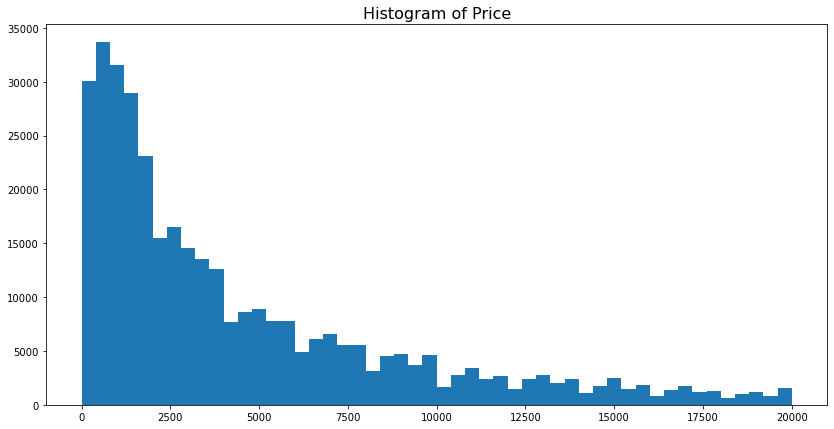

In [11]:
plt.figure(figsize = [14, 7])

plt.hist(data['price'], bins = 50)
plt.title('Histogram of Price', fontsize = 16)
plt.show()

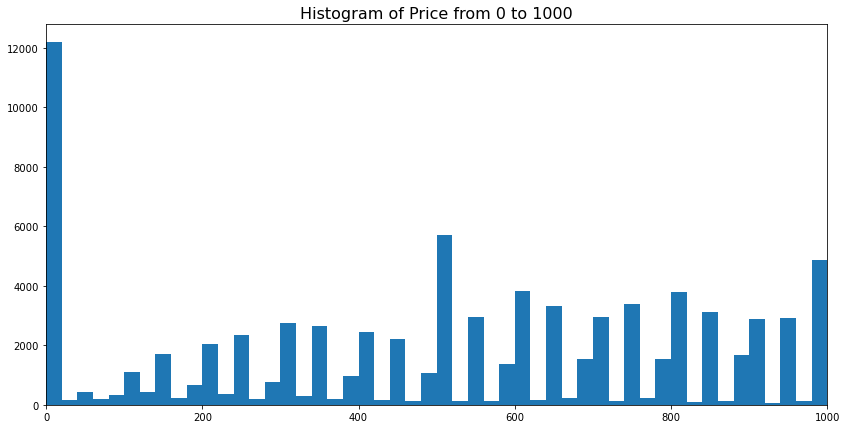

In [12]:
plt.figure(figsize = [14, 7])
plt.xlim([0, 1000])
plt.hist(data['price'], bins = 1000)
plt.title('Histogram of Price from 0 to 1000', fontsize = 16)
plt.show()

- Let's build boxplot

<Figure size 864x648 with 0 Axes>

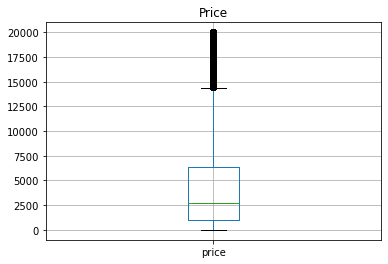

In [13]:
plt.figure(figsize = [12,9])
data.plot(kind = 'box', y = 'price', title = 'Price', grid = True)
plt.show()

*It is unlikely that such prices exist, it is difficult to indicate the minimum price, but for 500 euros I found cars, the current that we will remove from 0 to 450. We will leave values from 15000.*

In [14]:
data = data.query('price >= 450')
data.price.min()

450

- Let's take a closer look Power

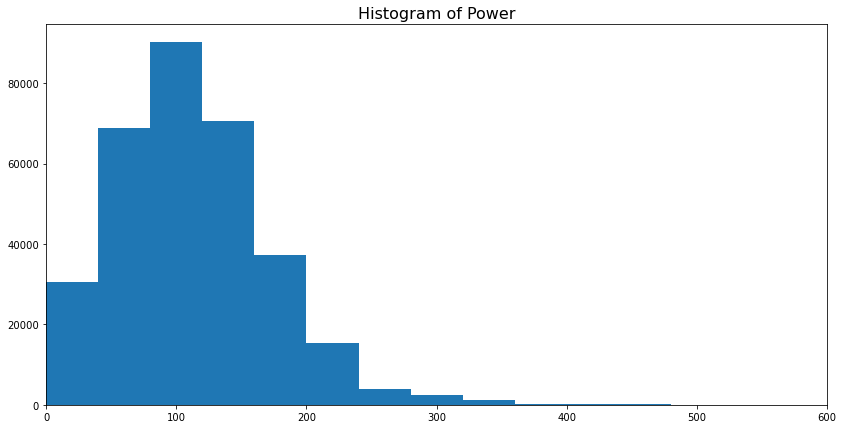

In [15]:
plt.figure(figsize = [14, 7])

plt.hist(data['power'], bins = 500)
plt.title('Histogram of Power', fontsize = 16)
plt.xlim([0, 600])
plt.show()

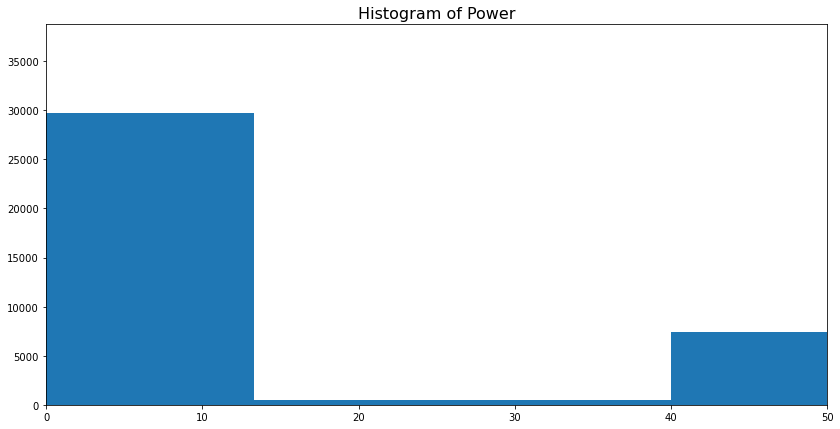

In [16]:
plt.figure(figsize = [14, 7])

plt.hist(data['power'], bins = 1500)
plt.title('Histogram of Power', fontsize = 16)
plt.xlim([0, 50])
plt.show()

<Figure size 1296x864 with 0 Axes>

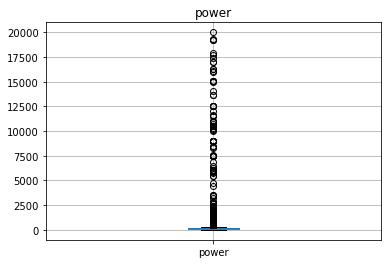

In [17]:
plt.figure(figsize = [18, 12])
data.plot(kind = 'box', y = 'power', title = 'power', grid = True)
plt.show()

*We will consider the smallest horse power from 20, and ordinary cars can hardly reach 550. Values from 600 will be considered emissions. Delete values up to 20 and from 600*

In [18]:
data = data.query('power > 20 and power <= 600')
print(data.power.min())
print(data.power.max())

21
600


- Let's look at registration year , we see that the minimum value is 1000 and the maximum is 9999

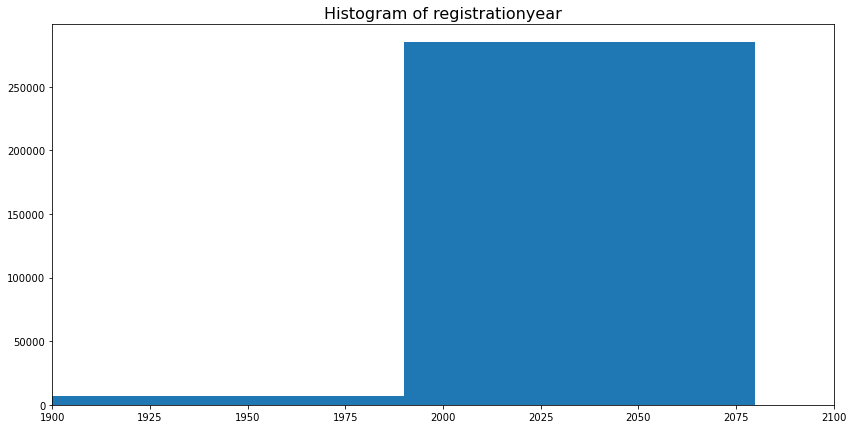

In [19]:
plt.figure(figsize = [14, 7])

plt.hist(data['registrationyear'], bins = 100)
plt.title('Histogram of registrationyear', fontsize = 16)
plt.xlim([1900, 2100])
plt.show()

<Figure size 864x648 with 0 Axes>

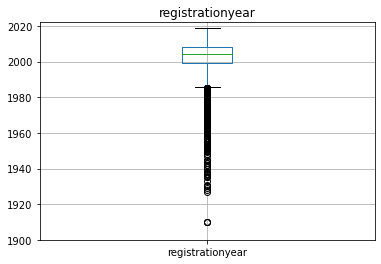

In [20]:
plt.figure(figsize = [12,9])
data.plot(kind = 'box', y = 'registrationyear', title = 'registrationyear', grid = True)
plt.ylim([1900, 2022])
plt.show()

*The maximum year of registration will be the last date of the questionnaire creation, and the minimum year is 1950*

In [21]:
data['datecreated'].max()

'2016-04-07 00:00:00'

In [22]:
data = data.query('1950 <= registrationyear <= 2016')
print(data.registrationyear.min())
print(data.registrationyear.max())

1950
2016


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281445 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        281445 non-null  object
 1   price              281445 non-null  int64 
 2   vehicletype        281445 non-null  object
 3   registrationyear   281445 non-null  int64 
 4   gearbox            281445 non-null  object
 5   power              281445 non-null  int64 
 6   model              281445 non-null  object
 7   kilometer          281445 non-null  int64 
 8   registrationmonth  281445 non-null  int64 
 9   fueltype           281445 non-null  object
 10  brand              281445 non-null  object
 11  notrepaired        281445 non-null  object
 12  datecreated        281445 non-null  object
 13  numberofpictures   281445 non-null  int64 
 14  postalcode         281445 non-null  int64 
 15  lastseen           281445 non-null  object
dtypes: int64(7), object(

*To build models, the following columns will interfere with us: lastseen, postalcode, numberofpictures, datecreated, registrationmonth, datecrawled Let's delete them.*

In [24]:
data = data.drop(['lastseen', 'postalcode', 'numberofpictures', 'datecreated', 'registrationmonth', 'datecrawled'], axis = 1)

In [25]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


- Now let's check the feature correlation.

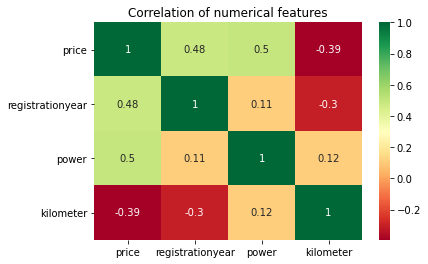

In [26]:
sns.heatmap(data.corr(), annot = True, cmap ='RdYlGn')
plt.title('Correlation of numerical features')
plt.show()

*As expected, the price of a car is most affected by the year of registration and power.*

### Preparing to Train Models

To predict the price of a car, we will use:

- LightGBM
- Catboost
- Linear Regression

 *For Linear Regression we will use the OHE method to encode categorical features. Then we split the data into training and test sets (80 / 20)*


In [27]:
data_ohe = pd.get_dummies(data, drop_first = True )

target_linear = data_ohe['price']
features_linear = data_ohe.drop(['price'], axis = 1)

features_train_linear, features_test_linear, target_train_linear, target_test_linear = train_test_split(
   features_linear, target_linear, test_size = 0.2, random_state = 12345)

In [28]:
features_train_linear.shape

(225156, 310)

In [29]:
features_test_linear.shape

(56289, 310)

*Now we can do scaling of numerical features:*

In [30]:
scaler = StandardScaler()
numerical = ['registrationyear', 'power', 'kilometer']
scaler.fit(features_train_linear[numerical])

pd.options.mode.chained_assignment = None


features_train_linear[numerical] = scaler.transform(features_train_linear[numerical])
features_test_linear[numerical] = scaler.transform(features_test_linear[numerical])



features_train_linear.head()




,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
278928,0.146461,-1.204713,-0.078291,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
112689,0.614851,0.951165,0.601320,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
174011,-0.165799,-1.279054,0.601320,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
338133,1.083242,0.616632,-1.573436,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28481,0.458721,0.746728,-0.078291,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
features_test_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
248261,0.770982,-0.126774,-0.078291,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
261165,1.083242,-1.018862,-2.932659,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
352802,0.927112,-1.167543,-0.078291,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
308043,0.614851,1.006921,0.601320,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209333,1.083242,4.036301,-0.078291,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


*The gradient boosting models that we will use can work with categorical features, the only thing that cannot work with the object type. change the type of categorical features to category.*

In [32]:
category = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

for col in category:
    data[col] = data[col].astype('category')
    
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281445 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             281445 non-null  int64   
 1   vehicletype       281445 non-null  category
 2   registrationyear  281445 non-null  int64   
 3   gearbox           281445 non-null  category
 4   power             281445 non-null  int64   
 5   model             281445 non-null  category
 6   kilometer         281445 non-null  int64   
 7   fueltype          281445 non-null  category
 8   brand             281445 non-null  category
 9   notrepaired       281445 non-null  category
dtypes: category(6), int64(4)
memory usage: 12.6 MB


*Let's split the data into training and test sets.*

In [33]:
target_boost = data['price']
features_boost = data.drop(['price'], axis = 1)

features_train_boost , features_test_boost, target_train_boost, target_test_boost = train_test_split(
features_boost , target_boost , test_size = 0.2, random_state = 12345)

In [34]:
features_train_boost.shape

(225156, 9)

In [35]:
target_train_boost.shape

(225156,)

*Perform scaling of numerical features.*

In [36]:
scaler.fit(features_train_boost[numerical])

pd.options.mode.chained_assignment = None


features_train_boost[numerical] = scaler.transform(features_train_boost[numerical])
features_test_boost[numerical] = scaler.transform(features_test_boost[numerical])



features_train_boost.head()



,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
278928,small,0.146461,manual,-1.204713,twingo,-0.078291,petrol,renault,no
112689,bus,0.614851,manual,0.951165,transporter,0.601320,gasoline,volkswagen,no
174011,small,-0.165799,manual,-1.279054,polo,0.601320,petrol,volkswagen,no
338133,convertible,1.083242,auto,0.616632,3_reihe,-1.573436,petrol,peugeot,no
28481,sedan,0.458721,manual,0.746728,a4,-0.078291,petrol,audi,no


*Let's create a model that will calculate the training time, prediction time and RMSE models:*

In [37]:
def model_final(model , X_train, y_train , X_test, y_test):
    
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return train_time, pred_time, rmse

## Train model :

- Linear Regression 

In [38]:
model_linear = LinearRegression()
parametrs = {'fit_intercept': [True, False],
            'normalize': [True, False]}
             

grid_linear = GridSearchCV(model_linear, parametrs, cv = 5,
                          n_jobs = 1, verbose = 0,
                          scoring='neg_mean_squared_error')

train_time_linear, pred_time_linear, rmse_linear = model_final(grid_linear,
                                                               features_train_linear,
                                                               target_train_linear,
                                                               features_test_linear,
                                                               target_test_linear)
print('Training time :', train_time_linear, 'sec') 
print('Prediction time :', pred_time_linear, 'sec')
print('RMSE model :', rmse_linear, 'euro' )

Training time : 37.94727420806885 sec
Prediction time : 0.05245494842529297 sec
RMSE model : 2548.804203657877 euro


- Cat Boost 

In [39]:
model_cat = CatBoostRegressor(cat_features=category, loss_function='RMSE')

cat_params = {'depth' : [3, 6 ,9],
             'iterations' : [25, 50, 75],
              'learning_rate' : [0.05, 0,1]}
grid_cat = GridSearchCV(model_cat, cat_params , 
                       cv = 5,
                       n_jobs = 1,
                       verbose = 0, 
                       scoring='neg_mean_squared_error') 
                        

train_time_cat, pred_time_cat, rmse_cat = model_final(grid_cat,
                                                      features_train_boost,
                                                      target_train_boost,
                                                      features_test_boost,
                                                      target_test_boost)
print('Training time :', train_time_cat, 'sec') 
print('Prediction time :', pred_time_cat, 'sec')
print('RMSE model :', rmse_cat, 'euro' )                

0:	learn: 4490.6155259	total: 74.2ms	remaining: 1.78s
1:	learn: 4370.5810296	total: 85.9ms	remaining: 987ms
2:	learn: 4259.5508416	total: 99.9ms	remaining: 733ms
3:	learn: 4155.5989603	total: 111ms	remaining: 584ms
4:	learn: 4056.8639548	total: 126ms	remaining: 504ms
5:	learn: 3963.1750900	total: 139ms	remaining: 440ms
6:	learn: 3876.0331985	total: 150ms	remaining: 386ms
7:	learn: 3793.6224472	total: 161ms	remaining: 343ms
8:	learn: 3713.8345897	total: 173ms	remaining: 308ms
9:	learn: 3642.8145296	total: 185ms	remaining: 278ms
10:	learn: 3573.0513101	total: 196ms	remaining: 250ms
11:	learn: 3508.3159098	total: 208ms	remaining: 225ms
12:	learn: 3446.1730245	total: 219ms	remaining: 202ms
13:	learn: 3389.1623143	total: 229ms	remaining: 180ms
14:	learn: 3333.6988823	total: 240ms	remaining: 160ms
15:	learn: 3283.1273104	total: 251ms	remaining: 141ms
16:	learn: 3232.7866535	total: 262ms	remaining: 123ms
17:	learn: 3184.3748370	total: 273ms	remaining: 106ms
18:	learn: 3136.8157697	total: 284m

17:	learn: 1971.3992984	total: 216ms	remaining: 84ms
18:	learn: 1961.7530833	total: 226ms	remaining: 71.5ms
19:	learn: 1951.7809363	total: 237ms	remaining: 59.1ms
20:	learn: 1943.8738095	total: 247ms	remaining: 47.1ms
21:	learn: 1934.7630912	total: 257ms	remaining: 35.1ms
22:	learn: 1925.3108396	total: 268ms	remaining: 23.3ms
23:	learn: 1913.7979488	total: 279ms	remaining: 11.6ms
24:	learn: 1905.5200817	total: 289ms	remaining: 0us
0:	learn: 3093.0980229	total: 13.4ms	remaining: 321ms
1:	learn: 2712.6292865	total: 26.4ms	remaining: 303ms
2:	learn: 2534.2931231	total: 37ms	remaining: 271ms
3:	learn: 2405.7052796	total: 48.7ms	remaining: 255ms
4:	learn: 2303.2199733	total: 58.8ms	remaining: 235ms
5:	learn: 2250.8653612	total: 72ms	remaining: 228ms
6:	learn: 2201.2573550	total: 83ms	remaining: 213ms
7:	learn: 2160.4521746	total: 105ms	remaining: 223ms
8:	learn: 2132.4498765	total: 118ms	remaining: 210ms
9:	learn: 2099.1276911	total: 136ms	remaining: 204ms
10:	learn: 2076.7826054	total: 147

33:	learn: 2671.0590238	total: 415ms	remaining: 195ms
34:	learn: 2649.4578452	total: 432ms	remaining: 185ms
35:	learn: 2629.2274602	total: 448ms	remaining: 174ms
36:	learn: 2607.9784491	total: 466ms	remaining: 164ms
37:	learn: 2590.0318897	total: 480ms	remaining: 151ms
38:	learn: 2571.7140905	total: 494ms	remaining: 139ms
39:	learn: 2553.4812277	total: 506ms	remaining: 127ms
40:	learn: 2534.5449214	total: 519ms	remaining: 114ms
41:	learn: 2518.1905405	total: 532ms	remaining: 101ms
42:	learn: 2501.6607445	total: 547ms	remaining: 89ms
43:	learn: 2487.6751240	total: 563ms	remaining: 76.7ms
44:	learn: 2472.7465071	total: 576ms	remaining: 64ms
45:	learn: 2457.1648987	total: 587ms	remaining: 51.1ms
46:	learn: 2443.3664024	total: 601ms	remaining: 38.4ms
47:	learn: 2430.4440973	total: 615ms	remaining: 25.6ms
48:	learn: 2415.9110451	total: 631ms	remaining: 12.9ms
49:	learn: 2404.7493031	total: 651ms	remaining: 0us
0:	learn: 4485.0063362	total: 13.4ms	remaining: 658ms
1:	learn: 4364.5568403	tota

35:	learn: 2628.9015157	total: 385ms	remaining: 150ms
36:	learn: 2607.7618889	total: 396ms	remaining: 139ms
37:	learn: 2588.8496990	total: 405ms	remaining: 128ms
38:	learn: 2571.2183674	total: 415ms	remaining: 117ms
39:	learn: 2552.6928954	total: 426ms	remaining: 106ms
40:	learn: 2535.2938192	total: 436ms	remaining: 95.7ms
41:	learn: 2517.7198049	total: 447ms	remaining: 85.1ms
42:	learn: 2500.8505987	total: 457ms	remaining: 74.3ms
43:	learn: 2485.2914403	total: 467ms	remaining: 63.7ms
44:	learn: 2470.8054443	total: 478ms	remaining: 53.1ms
45:	learn: 2454.0572900	total: 488ms	remaining: 42.4ms
46:	learn: 2438.0505649	total: 498ms	remaining: 31.8ms
47:	learn: 2425.2180997	total: 508ms	remaining: 21.2ms
48:	learn: 2410.9472355	total: 518ms	remaining: 10.6ms
49:	learn: 2399.5180218	total: 529ms	remaining: 0us
0:	learn: 3099.8473507	total: 17ms	remaining: 835ms
1:	learn: 2771.5182117	total: 27.6ms	remaining: 661ms
2:	learn: 2600.0268787	total: 41.3ms	remaining: 647ms
3:	learn: 2471.1147743	

0:	learn: 3098.0700073	total: 12.6ms	remaining: 616ms
1:	learn: 2715.3409842	total: 24.8ms	remaining: 596ms
2:	learn: 2541.0177852	total: 36.2ms	remaining: 568ms
3:	learn: 2413.0672988	total: 48.5ms	remaining: 558ms
4:	learn: 2308.9946712	total: 58.7ms	remaining: 528ms
5:	learn: 2257.5605268	total: 71.4ms	remaining: 523ms
6:	learn: 2212.3465536	total: 81.9ms	remaining: 503ms
7:	learn: 2174.3381380	total: 92.9ms	remaining: 488ms
8:	learn: 2145.5029183	total: 103ms	remaining: 471ms
9:	learn: 2118.0960323	total: 113ms	remaining: 452ms
10:	learn: 2090.5546034	total: 123ms	remaining: 436ms
11:	learn: 2069.6956710	total: 133ms	remaining: 421ms
12:	learn: 2054.5203182	total: 144ms	remaining: 409ms
13:	learn: 2033.9975194	total: 153ms	remaining: 395ms
14:	learn: 2017.1866118	total: 165ms	remaining: 385ms
15:	learn: 2001.3088612	total: 176ms	remaining: 375ms
16:	learn: 1988.5749707	total: 187ms	remaining: 363ms
17:	learn: 1977.9221464	total: 198ms	remaining: 351ms
18:	learn: 1969.7842044	total:

59:	learn: 2300.1682029	total: 624ms	remaining: 156ms
60:	learn: 2291.8097404	total: 634ms	remaining: 146ms
61:	learn: 2283.5070450	total: 644ms	remaining: 135ms
62:	learn: 2275.8897522	total: 654ms	remaining: 125ms
63:	learn: 2267.8441447	total: 665ms	remaining: 114ms
64:	learn: 2258.5373032	total: 675ms	remaining: 104ms
65:	learn: 2252.2069002	total: 686ms	remaining: 93.5ms
66:	learn: 2245.7022038	total: 696ms	remaining: 83.1ms
67:	learn: 2239.6290885	total: 706ms	remaining: 72.6ms
68:	learn: 2230.8597399	total: 716ms	remaining: 62.2ms
69:	learn: 2222.7463407	total: 725ms	remaining: 51.8ms
70:	learn: 2215.5556732	total: 735ms	remaining: 41.4ms
71:	learn: 2209.8454688	total: 746ms	remaining: 31.1ms
72:	learn: 2202.8464986	total: 756ms	remaining: 20.7ms
73:	learn: 2196.5962283	total: 766ms	remaining: 10.4ms
74:	learn: 2189.1054999	total: 777ms	remaining: 0us
0:	learn: 4488.0290343	total: 12.3ms	remaining: 913ms
1:	learn: 4371.6309231	total: 24.1ms	remaining: 881ms
2:	learn: 4259.504314

0:	learn: 4489.7181729	total: 12.4ms	remaining: 917ms
1:	learn: 4369.5404365	total: 24.6ms	remaining: 899ms
2:	learn: 4259.9460763	total: 34.4ms	remaining: 826ms
3:	learn: 4154.6038478	total: 44.4ms	remaining: 788ms
4:	learn: 4055.7852273	total: 54.1ms	remaining: 757ms
5:	learn: 3959.8009829	total: 64.2ms	remaining: 738ms
6:	learn: 3871.6374328	total: 74.2ms	remaining: 721ms
7:	learn: 3789.0628706	total: 86.8ms	remaining: 727ms
8:	learn: 3711.8316746	total: 96.7ms	remaining: 709ms
9:	learn: 3639.1330317	total: 107ms	remaining: 695ms
10:	learn: 3572.5169276	total: 117ms	remaining: 680ms
11:	learn: 3506.2655056	total: 127ms	remaining: 665ms
12:	learn: 3446.7513870	total: 137ms	remaining: 653ms
13:	learn: 3389.7043605	total: 148ms	remaining: 643ms
14:	learn: 3335.9880955	total: 158ms	remaining: 631ms
15:	learn: 3284.3865547	total: 168ms	remaining: 619ms
16:	learn: 3230.7173739	total: 178ms	remaining: 607ms
17:	learn: 3184.9157539	total: 187ms	remaining: 593ms
18:	learn: 3143.6203180	total

15:	learn: 1994.7245763	total: 221ms	remaining: 816ms
16:	learn: 1982.2934409	total: 234ms	remaining: 798ms
17:	learn: 1972.3858190	total: 248ms	remaining: 787ms
18:	learn: 1959.6879779	total: 266ms	remaining: 783ms
19:	learn: 1950.6895272	total: 283ms	remaining: 779ms
20:	learn: 1943.0807414	total: 301ms	remaining: 775ms
21:	learn: 1938.5514572	total: 316ms	remaining: 760ms
22:	learn: 1929.3700592	total: 331ms	remaining: 749ms
23:	learn: 1923.5469584	total: 347ms	remaining: 737ms
24:	learn: 1918.7526836	total: 359ms	remaining: 718ms
25:	learn: 1914.2046352	total: 374ms	remaining: 704ms
26:	learn: 1904.9487627	total: 386ms	remaining: 686ms
27:	learn: 1892.9871572	total: 398ms	remaining: 667ms
28:	learn: 1887.4995514	total: 412ms	remaining: 653ms
29:	learn: 1882.5995087	total: 426ms	remaining: 640ms
30:	learn: 1877.2382122	total: 442ms	remaining: 627ms
31:	learn: 1872.9205198	total: 463ms	remaining: 622ms
32:	learn: 1863.2518772	total: 485ms	remaining: 617ms
33:	learn: 1857.8211835	tota

17:	learn: 1975.2101781	total: 204ms	remaining: 645ms
18:	learn: 1963.3250731	total: 214ms	remaining: 632ms
19:	learn: 1956.5963882	total: 226ms	remaining: 620ms
20:	learn: 1951.0425251	total: 236ms	remaining: 607ms
21:	learn: 1941.9919560	total: 246ms	remaining: 594ms
22:	learn: 1934.9095237	total: 257ms	remaining: 581ms
23:	learn: 1925.4227945	total: 268ms	remaining: 570ms
24:	learn: 1918.6626855	total: 279ms	remaining: 558ms
25:	learn: 1910.3067928	total: 289ms	remaining: 545ms
26:	learn: 1900.6646554	total: 300ms	remaining: 533ms
27:	learn: 1897.0431773	total: 310ms	remaining: 521ms
28:	learn: 1892.7029340	total: 320ms	remaining: 508ms
29:	learn: 1886.7408088	total: 331ms	remaining: 496ms
30:	learn: 1883.3931026	total: 341ms	remaining: 484ms
31:	learn: 1878.2796473	total: 351ms	remaining: 471ms
32:	learn: 1871.6390149	total: 361ms	remaining: 460ms
33:	learn: 1866.1511517	total: 372ms	remaining: 449ms
34:	learn: 1863.3503974	total: 383ms	remaining: 438ms
35:	learn: 1855.7926072	tota

36:	learn: 1858.8092149	total: 415ms	remaining: 426ms
37:	learn: 1857.1284515	total: 428ms	remaining: 417ms
38:	learn: 1853.1429412	total: 439ms	remaining: 406ms
39:	learn: 1849.9706162	total: 450ms	remaining: 394ms
40:	learn: 1846.6141616	total: 462ms	remaining: 383ms
41:	learn: 1844.3885213	total: 473ms	remaining: 372ms
42:	learn: 1840.1021087	total: 484ms	remaining: 360ms
43:	learn: 1836.4024342	total: 495ms	remaining: 349ms
44:	learn: 1833.7937935	total: 506ms	remaining: 337ms
45:	learn: 1828.2520680	total: 518ms	remaining: 326ms
46:	learn: 1825.8111345	total: 528ms	remaining: 315ms
47:	learn: 1821.5755956	total: 539ms	remaining: 303ms
48:	learn: 1819.5682773	total: 550ms	remaining: 292ms
49:	learn: 1817.8610651	total: 561ms	remaining: 280ms
50:	learn: 1815.7705386	total: 572ms	remaining: 269ms
51:	learn: 1812.5288198	total: 583ms	remaining: 258ms
52:	learn: 1811.3745231	total: 593ms	remaining: 246ms
53:	learn: 1809.1566628	total: 606ms	remaining: 236ms
54:	learn: 1807.2463040	tota

0:	learn: 2646.9674012	total: 19.6ms	remaining: 471ms
1:	learn: 2341.8867994	total: 42.7ms	remaining: 491ms
2:	learn: 2207.4315023	total: 60.4ms	remaining: 443ms
3:	learn: 2107.9901649	total: 77.1ms	remaining: 405ms
4:	learn: 2053.3219920	total: 97.1ms	remaining: 388ms
5:	learn: 2025.3689301	total: 117ms	remaining: 369ms
6:	learn: 1977.0150478	total: 136ms	remaining: 349ms
7:	learn: 1950.7605768	total: 156ms	remaining: 331ms
8:	learn: 1925.4435708	total: 175ms	remaining: 311ms
9:	learn: 1904.0409585	total: 194ms	remaining: 292ms
10:	learn: 1884.2197743	total: 210ms	remaining: 267ms
11:	learn: 1864.7448816	total: 225ms	remaining: 244ms
12:	learn: 1855.7364033	total: 244ms	remaining: 225ms
13:	learn: 1846.1111779	total: 264ms	remaining: 208ms
14:	learn: 1827.2253943	total: 283ms	remaining: 188ms
15:	learn: 1819.3499084	total: 302ms	remaining: 170ms
16:	learn: 1807.2964274	total: 318ms	remaining: 150ms
17:	learn: 1797.6825804	total: 335ms	remaining: 130ms
18:	learn: 1787.9592256	total: 35

38:	learn: 2236.6936797	total: 633ms	remaining: 179ms
39:	learn: 2220.0966017	total: 652ms	remaining: 163ms
40:	learn: 2203.0070232	total: 667ms	remaining: 146ms
41:	learn: 2186.8282875	total: 682ms	remaining: 130ms
42:	learn: 2171.1604023	total: 698ms	remaining: 114ms
43:	learn: 2156.8576125	total: 714ms	remaining: 97.4ms
44:	learn: 2144.3698852	total: 731ms	remaining: 81.2ms
45:	learn: 2128.6154010	total: 747ms	remaining: 64.9ms
46:	learn: 2115.1620723	total: 762ms	remaining: 48.6ms
47:	learn: 2102.8598758	total: 778ms	remaining: 32.4ms
48:	learn: 2090.9188525	total: 795ms	remaining: 16.2ms
49:	learn: 2080.0976586	total: 812ms	remaining: 0us
0:	learn: 4460.1854299	total: 18.2ms	remaining: 892ms
1:	learn: 4317.3640008	total: 35.3ms	remaining: 846ms
2:	learn: 4182.7429359	total: 51.1ms	remaining: 800ms
3:	learn: 4057.5169004	total: 66.8ms	remaining: 768ms
4:	learn: 3937.2086860	total: 82.4ms	remaining: 742ms
5:	learn: 3826.1520437	total: 97ms	remaining: 711ms
6:	learn: 3720.7415367	tot

40:	learn: 2213.7573871	total: 649ms	remaining: 142ms
41:	learn: 2197.5249131	total: 666ms	remaining: 127ms
42:	learn: 2181.9907149	total: 682ms	remaining: 111ms
43:	learn: 2167.2787068	total: 696ms	remaining: 94.9ms
44:	learn: 2150.7275606	total: 711ms	remaining: 79ms
45:	learn: 2136.0473107	total: 726ms	remaining: 63.1ms
46:	learn: 2122.3929028	total: 741ms	remaining: 47.3ms
47:	learn: 2110.0302882	total: 760ms	remaining: 31.7ms
48:	learn: 2097.4315958	total: 776ms	remaining: 15.8ms
49:	learn: 2086.8963984	total: 792ms	remaining: 0us
0:	learn: 4457.9915895	total: 20.5ms	remaining: 1s
1:	learn: 4315.6469033	total: 40.3ms	remaining: 967ms
2:	learn: 4180.6575621	total: 58.6ms	remaining: 918ms
3:	learn: 4055.2606584	total: 76.3ms	remaining: 878ms
4:	learn: 3935.2000245	total: 93.2ms	remaining: 839ms
5:	learn: 3826.2003430	total: 111ms	remaining: 811ms
6:	learn: 3721.4649579	total: 128ms	remaining: 786ms
7:	learn: 3624.0731761	total: 146ms	remaining: 768ms
8:	learn: 3530.9338004	total: 16

48:	learn: 1669.0711695	total: 831ms	remaining: 17ms
49:	learn: 1668.3187620	total: 848ms	remaining: 0us
0:	learn: 2648.2313810	total: 18.9ms	remaining: 928ms
1:	learn: 2366.3388047	total: 39.6ms	remaining: 951ms
2:	learn: 2182.0283479	total: 56.3ms	remaining: 883ms
3:	learn: 2105.0733888	total: 75.2ms	remaining: 865ms
4:	learn: 2040.4898019	total: 90.7ms	remaining: 816ms
5:	learn: 1994.0316269	total: 108ms	remaining: 795ms
6:	learn: 1963.2787525	total: 125ms	remaining: 770ms
7:	learn: 1927.1837559	total: 142ms	remaining: 746ms
8:	learn: 1902.8845976	total: 158ms	remaining: 720ms
9:	learn: 1885.3237840	total: 175ms	remaining: 699ms
10:	learn: 1875.7769766	total: 193ms	remaining: 683ms
11:	learn: 1863.2546076	total: 209ms	remaining: 661ms
12:	learn: 1853.0115508	total: 224ms	remaining: 638ms
13:	learn: 1842.0084454	total: 241ms	remaining: 619ms
14:	learn: 1827.7808661	total: 257ms	remaining: 599ms
15:	learn: 1812.8905486	total: 272ms	remaining: 578ms
16:	learn: 1802.0418134	total: 287ms

0:	learn: 4462.3224791	total: 17.3ms	remaining: 1.28s
1:	learn: 4320.6203183	total: 34.8ms	remaining: 1.27s
2:	learn: 4187.6000771	total: 49.5ms	remaining: 1.19s
3:	learn: 4061.2176826	total: 66.7ms	remaining: 1.18s
4:	learn: 3942.9754648	total: 81.7ms	remaining: 1.14s
5:	learn: 3828.1026396	total: 96.8ms	remaining: 1.11s
6:	learn: 3723.0791747	total: 112ms	remaining: 1.09s
7:	learn: 3623.9222920	total: 126ms	remaining: 1.06s
8:	learn: 3529.1775578	total: 142ms	remaining: 1.04s
9:	learn: 3444.0279801	total: 157ms	remaining: 1.02s
10:	learn: 3360.6336832	total: 171ms	remaining: 995ms
11:	learn: 3283.4086043	total: 187ms	remaining: 980ms
12:	learn: 3210.3599075	total: 203ms	remaining: 969ms
13:	learn: 3142.9514264	total: 220ms	remaining: 958ms
14:	learn: 3077.4260177	total: 237ms	remaining: 947ms
15:	learn: 3018.4733154	total: 254ms	remaining: 936ms
16:	learn: 2960.7283896	total: 269ms	remaining: 919ms
17:	learn: 2909.5126844	total: 285ms	remaining: 903ms
18:	learn: 2856.6396621	total: 3

13:	learn: 3143.4666355	total: 235ms	remaining: 1.02s
14:	learn: 3080.3649239	total: 252ms	remaining: 1.01s
15:	learn: 3018.6192419	total: 267ms	remaining: 984ms
16:	learn: 2962.7723779	total: 282ms	remaining: 963ms
17:	learn: 2911.0537192	total: 298ms	remaining: 943ms
18:	learn: 2856.3609001	total: 313ms	remaining: 924ms
19:	learn: 2806.7353976	total: 329ms	remaining: 906ms
20:	learn: 2757.7993059	total: 345ms	remaining: 886ms
21:	learn: 2711.0937242	total: 360ms	remaining: 866ms
22:	learn: 2666.8223245	total: 374ms	remaining: 846ms
23:	learn: 2628.6798135	total: 389ms	remaining: 826ms
24:	learn: 2589.1552854	total: 403ms	remaining: 805ms
25:	learn: 2552.1735436	total: 418ms	remaining: 787ms
26:	learn: 2518.3353612	total: 433ms	remaining: 769ms
27:	learn: 2486.2826318	total: 448ms	remaining: 753ms
28:	learn: 2456.0419179	total: 463ms	remaining: 735ms
29:	learn: 2427.9301357	total: 478ms	remaining: 717ms
30:	learn: 2401.9382597	total: 492ms	remaining: 699ms
31:	learn: 2376.5350584	tota

24:	learn: 2601.6771437	total: 419ms	remaining: 839ms
25:	learn: 2564.8966713	total: 437ms	remaining: 823ms
26:	learn: 2529.8746344	total: 452ms	remaining: 803ms
27:	learn: 2498.9192034	total: 466ms	remaining: 783ms
28:	learn: 2468.4616850	total: 483ms	remaining: 767ms
29:	learn: 2440.8435581	total: 500ms	remaining: 749ms
30:	learn: 2412.1065522	total: 514ms	remaining: 730ms
31:	learn: 2386.3211919	total: 530ms	remaining: 712ms
32:	learn: 2363.1749510	total: 545ms	remaining: 693ms
33:	learn: 2340.3157699	total: 561ms	remaining: 676ms
34:	learn: 2317.8713399	total: 577ms	remaining: 660ms
35:	learn: 2298.0673380	total: 593ms	remaining: 642ms
36:	learn: 2278.8871474	total: 608ms	remaining: 624ms
37:	learn: 2260.6181223	total: 625ms	remaining: 609ms
38:	learn: 2243.7417289	total: 642ms	remaining: 593ms
39:	learn: 2227.6683137	total: 658ms	remaining: 576ms
40:	learn: 2211.9890376	total: 675ms	remaining: 559ms
41:	learn: 2193.6353599	total: 690ms	remaining: 542ms
42:	learn: 2178.7807543	tota

36:	learn: 1698.2721020	total: 638ms	remaining: 655ms
37:	learn: 1694.7462969	total: 656ms	remaining: 639ms
38:	learn: 1692.1876408	total: 675ms	remaining: 623ms
39:	learn: 1690.2147345	total: 692ms	remaining: 606ms
40:	learn: 1688.2472989	total: 712ms	remaining: 590ms
41:	learn: 1685.0061876	total: 730ms	remaining: 573ms
42:	learn: 1682.8223929	total: 748ms	remaining: 556ms
43:	learn: 1681.0232249	total: 766ms	remaining: 540ms
44:	learn: 1679.0805431	total: 784ms	remaining: 523ms
45:	learn: 1677.1522496	total: 800ms	remaining: 505ms
46:	learn: 1675.0609612	total: 819ms	remaining: 488ms
47:	learn: 1672.3135046	total: 835ms	remaining: 470ms
48:	learn: 1669.0711695	total: 854ms	remaining: 453ms
49:	learn: 1668.3187620	total: 871ms	remaining: 436ms
50:	learn: 1667.6793975	total: 889ms	remaining: 418ms
51:	learn: 1664.6410381	total: 904ms	remaining: 400ms
52:	learn: 1663.0178219	total: 922ms	remaining: 383ms
53:	learn: 1661.5589414	total: 939ms	remaining: 365ms
54:	learn: 1660.0170853	tota

48:	learn: 1672.2250436	total: 855ms	remaining: 454ms
49:	learn: 1669.9854540	total: 872ms	remaining: 436ms
50:	learn: 1668.2692667	total: 889ms	remaining: 419ms
51:	learn: 1666.4095413	total: 907ms	remaining: 401ms
52:	learn: 1664.8455343	total: 924ms	remaining: 383ms
53:	learn: 1663.5537874	total: 943ms	remaining: 367ms
54:	learn: 1662.1170442	total: 960ms	remaining: 349ms
55:	learn: 1661.9477560	total: 978ms	remaining: 332ms
56:	learn: 1656.0663976	total: 994ms	remaining: 314ms
57:	learn: 1653.3689833	total: 1.01s	remaining: 295ms
58:	learn: 1650.4297890	total: 1.02s	remaining: 278ms
59:	learn: 1648.4972574	total: 1.04s	remaining: 260ms
60:	learn: 1645.9275863	total: 1.06s	remaining: 243ms
61:	learn: 1642.7287386	total: 1.07s	remaining: 226ms
62:	learn: 1641.6356912	total: 1.09s	remaining: 208ms
63:	learn: 1640.4488855	total: 1.11s	remaining: 191ms
64:	learn: 1639.2660787	total: 1.13s	remaining: 174ms
65:	learn: 1637.7062029	total: 1.15s	remaining: 156ms
66:	learn: 1635.3639899	tota

10:	learn: 3263.2741807	total: 246ms	remaining: 313ms
11:	learn: 3179.7166840	total: 269ms	remaining: 291ms
12:	learn: 3100.1639876	total: 290ms	remaining: 267ms
13:	learn: 3025.8877486	total: 312ms	remaining: 246ms
14:	learn: 2956.7421803	total: 336ms	remaining: 224ms
15:	learn: 2893.7981028	total: 358ms	remaining: 201ms
16:	learn: 2835.6068360	total: 389ms	remaining: 183ms
17:	learn: 2779.1239492	total: 410ms	remaining: 159ms
18:	learn: 2726.0194276	total: 433ms	remaining: 137ms
19:	learn: 2677.8322050	total: 455ms	remaining: 114ms
20:	learn: 2631.8649106	total: 478ms	remaining: 91.1ms
21:	learn: 2582.4857394	total: 500ms	remaining: 68.2ms
22:	learn: 2534.2392103	total: 521ms	remaining: 45.3ms
23:	learn: 2490.6257077	total: 542ms	remaining: 22.6ms
24:	learn: 2449.0071154	total: 562ms	remaining: 0us
0:	learn: 4450.7380178	total: 23.9ms	remaining: 573ms
1:	learn: 4297.3204785	total: 47.8ms	remaining: 550ms
2:	learn: 4154.8896057	total: 71.7ms	remaining: 526ms
3:	learn: 4019.4278507	tot

17:	learn: 1682.8915205	total: 448ms	remaining: 174ms
18:	learn: 1674.8738182	total: 474ms	remaining: 150ms
19:	learn: 1669.3863404	total: 500ms	remaining: 125ms
20:	learn: 1660.1122528	total: 521ms	remaining: 99.3ms
21:	learn: 1651.4851300	total: 544ms	remaining: 74.2ms
22:	learn: 1645.3463496	total: 566ms	remaining: 49.2ms
23:	learn: 1639.7449530	total: 590ms	remaining: 24.6ms
24:	learn: 1636.6347486	total: 616ms	remaining: 0us
0:	learn: 2447.5440370	total: 24ms	remaining: 576ms
1:	learn: 2155.2806619	total: 50.7ms	remaining: 583ms
2:	learn: 2037.0246022	total: 73.1ms	remaining: 536ms
3:	learn: 1957.2251897	total: 94.9ms	remaining: 498ms
4:	learn: 1917.6214348	total: 118ms	remaining: 471ms
5:	learn: 1861.9229210	total: 140ms	remaining: 444ms
6:	learn: 1831.3677035	total: 161ms	remaining: 415ms
7:	learn: 1814.4111147	total: 184ms	remaining: 392ms
8:	learn: 1791.7945693	total: 207ms	remaining: 367ms
9:	learn: 1775.9682155	total: 229ms	remaining: 344ms
10:	learn: 1757.9431398	total: 255

28:	learn: 2310.7782284	total: 664ms	remaining: 481ms
29:	learn: 2280.7078336	total: 688ms	remaining: 459ms
30:	learn: 2254.4051186	total: 709ms	remaining: 434ms
31:	learn: 2230.5608850	total: 731ms	remaining: 411ms
32:	learn: 2206.3509372	total: 752ms	remaining: 387ms
33:	learn: 2184.4072653	total: 773ms	remaining: 364ms
34:	learn: 2163.3324628	total: 794ms	remaining: 340ms
35:	learn: 2143.8267468	total: 815ms	remaining: 317ms
36:	learn: 2125.3585018	total: 836ms	remaining: 294ms
37:	learn: 2108.3078727	total: 857ms	remaining: 271ms
38:	learn: 2092.4980497	total: 881ms	remaining: 248ms
39:	learn: 2074.6398220	total: 903ms	remaining: 226ms
40:	learn: 2058.5660015	total: 926ms	remaining: 203ms
41:	learn: 2042.6490760	total: 946ms	remaining: 180ms
42:	learn: 2027.7213465	total: 967ms	remaining: 157ms
43:	learn: 2013.9547723	total: 987ms	remaining: 135ms
44:	learn: 2002.4300507	total: 1.01s	remaining: 112ms
45:	learn: 1991.0625912	total: 1.03s	remaining: 89.4ms
46:	learn: 1978.5997075	tot

35:	learn: 1584.5188549	total: 861ms	remaining: 335ms
36:	learn: 1578.1082036	total: 883ms	remaining: 310ms
37:	learn: 1574.7812140	total: 906ms	remaining: 286ms
38:	learn: 1570.4772802	total: 927ms	remaining: 261ms
39:	learn: 1567.4777908	total: 950ms	remaining: 237ms
40:	learn: 1564.1366395	total: 971ms	remaining: 213ms
41:	learn: 1560.9783323	total: 993ms	remaining: 189ms
42:	learn: 1557.9987691	total: 1.02s	remaining: 165ms
43:	learn: 1553.9576991	total: 1.04s	remaining: 142ms
44:	learn: 1551.4659935	total: 1.06s	remaining: 118ms
45:	learn: 1547.3076622	total: 1.08s	remaining: 94.3ms
46:	learn: 1545.6976131	total: 1.11s	remaining: 70.7ms
47:	learn: 1542.6484910	total: 1.13s	remaining: 47.2ms
48:	learn: 1540.1387252	total: 1.15s	remaining: 23.5ms
49:	learn: 1538.5931098	total: 1.18s	remaining: 0us
0:	learn: 2437.5181349	total: 26ms	remaining: 1.27s
1:	learn: 2171.5009632	total: 50.6ms	remaining: 1.21s
2:	learn: 2018.2260935	total: 71.8ms	remaining: 1.12s
3:	learn: 1942.5266027	total

44:	learn: 1549.3730904	total: 1.08s	remaining: 120ms
45:	learn: 1545.3707301	total: 1.1s	remaining: 96.2ms
46:	learn: 1542.3556618	total: 1.13s	remaining: 72.1ms
47:	learn: 1540.0145864	total: 1.15s	remaining: 48ms
48:	learn: 1538.0451831	total: 1.18s	remaining: 24ms
49:	learn: 1535.5781040	total: 1.2s	remaining: 0us
0:	learn: 2447.5440370	total: 24.9ms	remaining: 1.22s
1:	learn: 2155.2806619	total: 54.1ms	remaining: 1.3s
2:	learn: 2037.0246022	total: 77.2ms	remaining: 1.21s
3:	learn: 1957.2251897	total: 100ms	remaining: 1.15s
4:	learn: 1917.6214348	total: 124ms	remaining: 1.12s
5:	learn: 1861.9229210	total: 147ms	remaining: 1.07s
6:	learn: 1831.3677035	total: 169ms	remaining: 1.04s
7:	learn: 1814.4111147	total: 193ms	remaining: 1.01s
8:	learn: 1791.7945693	total: 215ms	remaining: 978ms
9:	learn: 1775.9682155	total: 236ms	remaining: 946ms
10:	learn: 1757.9431398	total: 260ms	remaining: 921ms
11:	learn: 1739.0925102	total: 281ms	remaining: 891ms
12:	learn: 1722.8674524	total: 303ms	rem

30:	learn: 2257.7502375	total: 654ms	remaining: 928ms
31:	learn: 2234.0806934	total: 674ms	remaining: 906ms
32:	learn: 2209.8291889	total: 694ms	remaining: 884ms
33:	learn: 2185.9087715	total: 714ms	remaining: 861ms
34:	learn: 2164.6595086	total: 734ms	remaining: 839ms
35:	learn: 2145.0311531	total: 756ms	remaining: 819ms
36:	learn: 2127.5457667	total: 777ms	remaining: 798ms
37:	learn: 2106.5380996	total: 797ms	remaining: 776ms
38:	learn: 2087.7453392	total: 818ms	remaining: 755ms
39:	learn: 2069.7935148	total: 838ms	remaining: 733ms
40:	learn: 2053.6171717	total: 859ms	remaining: 712ms
41:	learn: 2037.6052366	total: 881ms	remaining: 692ms
42:	learn: 2023.1590590	total: 901ms	remaining: 671ms
43:	learn: 2009.8139188	total: 921ms	remaining: 649ms
44:	learn: 1998.6423312	total: 941ms	remaining: 628ms
45:	learn: 1986.5743349	total: 961ms	remaining: 606ms
46:	learn: 1974.3933497	total: 982ms	remaining: 585ms
47:	learn: 1963.8304738	total: 1s	remaining: 564ms
48:	learn: 1951.0004103	total: 

39:	learn: 2068.4393772	total: 865ms	remaining: 757ms
40:	learn: 2052.1369964	total: 886ms	remaining: 735ms
41:	learn: 2037.5202542	total: 907ms	remaining: 713ms
42:	learn: 2023.9345214	total: 928ms	remaining: 691ms
43:	learn: 2010.7468582	total: 949ms	remaining: 668ms
44:	learn: 1998.8773073	total: 970ms	remaining: 647ms
45:	learn: 1986.4045528	total: 991ms	remaining: 625ms
46:	learn: 1975.9898053	total: 1.01s	remaining: 602ms
47:	learn: 1965.7949963	total: 1.03s	remaining: 581ms
48:	learn: 1955.3576994	total: 1.05s	remaining: 558ms
49:	learn: 1944.4530600	total: 1.07s	remaining: 538ms
50:	learn: 1934.7525959	total: 1.1s	remaining: 516ms
51:	learn: 1924.0738366	total: 1.12s	remaining: 495ms
52:	learn: 1915.3850238	total: 1.14s	remaining: 473ms
53:	learn: 1907.1665478	total: 1.16s	remaining: 452ms
54:	learn: 1899.4643089	total: 1.18s	remaining: 430ms
55:	learn: 1891.6016944	total: 1.2s	remaining: 408ms
56:	learn: 1884.7438542	total: 1.22s	remaining: 387ms
57:	learn: 1878.2644829	total:

45:	learn: 1547.3076622	total: 1.07s	remaining: 675ms
46:	learn: 1545.6976131	total: 1.09s	remaining: 653ms
47:	learn: 1542.6484910	total: 1.12s	remaining: 630ms
48:	learn: 1540.1387252	total: 1.14s	remaining: 607ms
49:	learn: 1538.5931098	total: 1.17s	remaining: 584ms
50:	learn: 1535.8128961	total: 1.19s	remaining: 562ms
51:	learn: 1531.3436091	total: 1.22s	remaining: 539ms
52:	learn: 1529.5591416	total: 1.24s	remaining: 515ms
53:	learn: 1523.8911617	total: 1.26s	remaining: 491ms
54:	learn: 1521.6390559	total: 1.28s	remaining: 468ms
55:	learn: 1516.8196318	total: 1.31s	remaining: 444ms
56:	learn: 1513.3250890	total: 1.33s	remaining: 420ms
57:	learn: 1510.6836350	total: 1.35s	remaining: 396ms
58:	learn: 1508.4684911	total: 1.38s	remaining: 373ms
59:	learn: 1507.5362249	total: 1.4s	remaining: 350ms
60:	learn: 1505.9968020	total: 1.42s	remaining: 327ms
61:	learn: 1502.1156687	total: 1.44s	remaining: 303ms
62:	learn: 1499.1044691	total: 1.47s	remaining: 279ms
63:	learn: 1493.9920959	total

53:	learn: 1518.6568501	total: 1.28s	remaining: 499ms
54:	learn: 1514.9436147	total: 1.3s	remaining: 474ms
55:	learn: 1512.5570103	total: 1.33s	remaining: 450ms
56:	learn: 1510.0377233	total: 1.35s	remaining: 426ms
57:	learn: 1508.7378137	total: 1.37s	remaining: 402ms
58:	learn: 1506.4615620	total: 1.39s	remaining: 378ms
59:	learn: 1504.4787974	total: 1.42s	remaining: 354ms
60:	learn: 1501.4542874	total: 1.44s	remaining: 330ms
61:	learn: 1498.7823493	total: 1.46s	remaining: 306ms
62:	learn: 1496.4491616	total: 1.48s	remaining: 283ms
63:	learn: 1494.5019057	total: 1.51s	remaining: 259ms
64:	learn: 1492.4630516	total: 1.53s	remaining: 236ms
65:	learn: 1489.5793726	total: 1.55s	remaining: 212ms
66:	learn: 1488.0740198	total: 1.58s	remaining: 188ms
67:	learn: 1485.4083139	total: 1.6s	remaining: 165ms
68:	learn: 1483.9842678	total: 1.63s	remaining: 142ms
69:	learn: 1481.5092005	total: 1.65s	remaining: 118ms
70:	learn: 1479.0431124	total: 1.68s	remaining: 94.4ms
71:	learn: 1476.9106357	total

63:	learn: 1489.2901775	total: 1.51s	remaining: 259ms
64:	learn: 1487.7216455	total: 1.53s	remaining: 236ms
65:	learn: 1484.1206697	total: 1.55s	remaining: 212ms
66:	learn: 1483.0914870	total: 1.58s	remaining: 188ms
67:	learn: 1480.5112244	total: 1.6s	remaining: 165ms
68:	learn: 1479.1757574	total: 1.63s	remaining: 141ms
69:	learn: 1478.1102512	total: 1.65s	remaining: 118ms
70:	learn: 1475.1353925	total: 1.67s	remaining: 94.2ms
71:	learn: 1472.9128109	total: 1.7s	remaining: 70.7ms
72:	learn: 1470.2297330	total: 1.72s	remaining: 47.1ms
73:	learn: 1468.7945277	total: 1.75s	remaining: 23.6ms
74:	learn: 1467.2204716	total: 1.77s	remaining: 0us
0:	learn: 2506.5971028	total: 30.2ms	remaining: 2.23s
1:	learn: 2188.5190969	total: 61.9ms	remaining: 2.26s
2:	learn: 2077.2672712	total: 90.7ms	remaining: 2.17s
3:	learn: 1972.2749788	total: 118ms	remaining: 2.1s
4:	learn: 1910.2393789	total: 147ms	remaining: 2.06s
5:	learn: 1866.9848849	total: 175ms	remaining: 2.01s
6:	learn: 1840.8502029	total: 20

In [40]:
print(grid_cat.best_params_)

{'depth': 9, 'iterations': 75, 'learning_rate': 1}


- LGBMRegressor

In [41]:
model_LGBM = LGBMRegressor(categorical_features=category)

LGBM_params = {'learning_rate' : [0.05, 0.1],
              'n_estimators' : [100, 200, 300],
              'max_depth' : [-1, -2, -3]}

grid_LGBM = GridSearchCV(model_LGBM, LGBM_params , 
                       cv = 5,
                       n_jobs = 1,
                       verbose = 0, 
                       scoring='neg_mean_squared_error') 
                        

train_time_LGBM, pred_time_LGBM, rmse_LGBM = model_final(grid_LGBM,
                                                      features_train_boost,
                                                      target_train_boost,
                                                      features_test_boost,
                                                      target_test_boost)
print('Training time :', train_time_LGBM, 'sec') 
print('Prediction time :', pred_time_LGBM, 'sec')
print('RMSE model :', rmse_LGBM, 'euro' )             

Training time : 131.93106818199158 sec
Prediction time : 0.18197989463806152 sec
RMSE model : 1534.9045524558207 euro


In [42]:
print(grid_LGBM.best_params_)

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300}


## Model Analysis :

In [43]:
results = {'Training time' : [train_time_linear, train_time_cat, train_time_LGBM],
          'Prediction time' : [pred_time_linear, pred_time_cat, pred_time_LGBM],
          'RMSE model' : [rmse_linear, rmse_cat, rmse_LGBM]}

result_table = pd.DataFrame(results)
result_table.index = ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor']
result_table = result_table.round(2)
display(result_table)

,Training time,Prediction time,RMSE model
LinearRegression,37.95,0.05,2548.80
CatBoostRegressor,101.08,0.04,1615.34
LGBMRegressor,131.93,0.18,1534.90


## Output :

Since all three parameters are important to the customer: the minimum RMSE, the minimum training and prediction time, the cat model showed itself best, although it has a slightly higher RMSE than LGMB, but the training and prediction time is less. If you look at the LinearRegression model, we see that it learns even faster than the cat, but the RMSE is much larger.